In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')

In [ ]:
import torch
import albumentations as A
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader, Subset
from albumentations.pytorch import ToTensorV2

# Required constants.
ROOT_DIR = '/content/drive/MyDrive/Colab Notebooks/CTSRB_Clear'
ROOT_DIR2 = '/content/drive/MyDrive/Colab Notebooks/CTSRB_Train'
VALID_SPLIT = 0.1
RESIZE_TO = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 10
NUM_WORKERS = 2 # Number of parallel processes for data preparation.

# Training transforms.
class TrainTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                ),
            ToTensorV2()
        ])
    
    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

# Validation transforms.
class ValidTransforms:
    def __init__(self, resize_to):
        self.transforms = A.Compose([
            A.Resize(resize_to, resize_to),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
                ),
            ToTensorV2()
        ])
    
    def __call__(self, img):
        return self.transforms(image=np.array(img))['image']

def get_datasets():
    """
    Function to prepare the Datasets.

    Returns the training and validation datasets along 
    with the class names.
    """
    dataset = datasets.ImageFolder(
        ROOT_DIR, 
        transform=(TrainTransforms(RESIZE_TO))
    )

    dataset_test = datasets.ImageFolder(
        ROOT_DIR2, 
        transform=(ValidTransforms(RESIZE_TO))
    )
    dataset_size = len(dataset)
    dataset_test_size = len(dataset_test)

    # Calculate the validation dataset size.
    valid_size = int(dataset_size)
    valid_size2 = int(dataset_test_size)

    # Radomize the data indices.
    indices = torch.randperm(len(dataset)).tolist()
    #indices2 = torch.randperm(len(dataset_test)).tolist()
    indices2 = [i for i in range(len(dataset_test))]
    # Training and validation sets.
    dataset_train = Subset(dataset, indices[:valid_size])
    dataset_valid = Subset(dataset_test, indices2[:valid_size2])

    return dataset_train, dataset_valid, dataset.classes

def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.

    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.

    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE, 
        shuffle=False, num_workers=NUM_WORKERS
    )
    return train_loader, valid_loader  

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

def build_model(pretrained=True, fine_tune=False, num_classes=10):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.mobilenet_v3_large(pretrained=pretrained)

    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[3] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

device = ('cuda' if torch.cuda.is_available() else 'cpu')

dataset_train, dataset_valid, dataset_classes = get_datasets()  
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

model = build_model(
        pretrained=True,
        fine_tune=True, 
        num_classes=len(dataset_classes)
    ).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


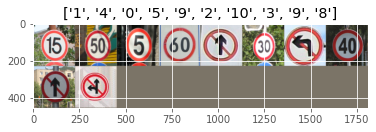

In [ ]:
import torchvision
from torchvision import datasets, models, transforms

def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
   
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dataset_classes[x] for x in classes])

In [ ]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time
import easydict
from tqdm.auto import tqdm


num_epochs = 75
model.train()
start_time = time.time()

valid_running_loss = 0.0
valid_running_correct = 0
counter = 0

with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataset_train)
    epoch_acc = running_corrects / len(dataset_train) * 100.
    
    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

  0%|          | 0/12 [00:00<?, ?it/s]

#0 Loss: 2.3766 Acc: 8.3333% Time: 0.9401s
#1 Loss: 1.8266 Acc: 83.3333% Time: 1.2551s
#2 Loss: 1.4149 Acc: 100.0000% Time: 1.5793s
#3 Loss: 1.1609 Acc: 100.0000% Time: 1.8875s
#4 Loss: 0.8739 Acc: 100.0000% Time: 2.2074s
#5 Loss: 0.6752 Acc: 100.0000% Time: 2.5316s
#6 Loss: 0.5085 Acc: 100.0000% Time: 2.8386s
#7 Loss: 0.3717 Acc: 100.0000% Time: 3.1735s
#8 Loss: 0.2994 Acc: 100.0000% Time: 3.4881s
#9 Loss: 0.2145 Acc: 100.0000% Time: 3.8100s
#10 Loss: 0.1587 Acc: 100.0000% Time: 4.1361s
#11 Loss: 0.1169 Acc: 100.0000% Time: 4.4700s
#12 Loss: 0.0880 Acc: 100.0000% Time: 4.8099s
#13 Loss: 0.0776 Acc: 100.0000% Time: 5.1330s
#14 Loss: 0.0570 Acc: 100.0000% Time: 5.4378s
#15 Loss: 0.0428 Acc: 100.0000% Time: 5.7555s
#16 Loss: 0.0309 Acc: 100.0000% Time: 6.0750s
#17 Loss: 0.0331 Acc: 100.0000% Time: 6.3836s
#18 Loss: 0.0250 Acc: 100.0000% Time: 6.7056s
#19 Loss: 0.0234 Acc: 100.0000% Time: 7.0155s
#20 Loss: 0.0195 Acc: 100.0000% Time: 7.3268s
#21 Loss: 0.0175 Acc: 100.0000% Time: 7.6514s
#

In [ ]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        c, preds = torch.max(outputs, 1)        
        loss = criterion(outputs, labels)

        _, idx = torch.max(c, 0)
        prediction = preds[idx]
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(prediction == labels.data[0])
        #print(preds)
        
        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {dataset_classes[prediction]}] (실제 정답: {dataset_classes[labels.data[0]]})')
        #imshow(inputs.cpu().data[1], title='prediction: ' + dataset_classes[prediction])
    
    epoch_loss = running_loss / len(dataset_valid)
    epoch_acc = running_corrects / (len(dataset_valid)/10) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

[예측 결과: 0] (실제 정답: 0)
[예측 결과: 1] (실제 정답: 1)
[예측 결과: 9] (실제 정답: 10)
[예측 결과: 1] (실제 정답: 2)
[예측 결과: 4] (실제 정답: 3)
[예측 결과: 6] (실제 정답: 4)
[예측 결과: 6] (실제 정답: 5)
[예측 결과: 6] (실제 정답: 6)
[예측 결과: 5] (실제 정답: 7)
[예측 결과: 8] (실제 정답: 8)
[예측 결과: 9] (실제 정답: 8)
[예측 결과: 9] (실제 정답: 9)
111
[Test Phase] Loss: 2.1882 Acc: 45.0450% Time: 0.6088s
